In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker
import radical.entk as re

In [2]:
! radical-stack


  python               : 3.7.7
  pythonpath           : 
  virtualenv           : /Users/mturilli/Virtualenvs/princeton-pa

  radical.analytics    : 0.90.7-v0.72.0-44-ge31c6b0@fix-plot_origin
  radical.entk         : 1.0.2
  radical.pilot        : 1.3.0
  radical.saga         : 1.3.0
  radical.utils        : 1.3.1



In [3]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Exec',      ['exec_queue', 'exec_prep']],
        ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Exec Cmd',          ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [4]:
suds = ['re.session.login4.lei.018394.0005',
        're.session.login5.lei.018411.0002',
        're.session.login4.lei.018394.0006',
        're.session.login5.lei.018411.0003']
sdir = '../data/raw/'
sids = [sdir+s for s in suds]

In [5]:
ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

In [6]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})

In [7]:
for sid in suds:
    print("""
%s:
\tName of the HPC platform: %s
\tPilot launch method: %s
\tNumber of pilots requested: %i
\tNumber of pilots active: %i
\tNumber of requested cores: %i
\tNumber of requested GPUs: %s
\tNumber of requested nodes: %s
\tNumber of nodes asked by ENTK: %i
\tNumber of tasks executed by EnTK: %i
\tNumber of tasks successfully executed by EnTK: %i
\tNumber of failed tasks: %i
""" % (sid              , ss[sid]['pres']  , ss[sid]['lm'], 
       ss[sid]['npilot'], ss[sid]['npact'] , ss[sid]['ncores']/4, 
       ss[sid]['ngpus'] , ss[sid]['nnodes'], ss[sid]['ncores']/168, 
       ss[sid]['nunit'] , ss[sid]['nudone'], ss[sid]['nufail']))


re.session.login4.lei.018394.0005:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 210
	Number of requested GPUs: 30
	Number of requested nodes: 5.0
	Number of nodes asked by ENTK: 5
	Number of tasks executed by EnTK: 10
	Number of tasks successfully executed by EnTK: 10
	Number of failed tasks: 0


re.session.login5.lei.018411.0002:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 13440
	Number of requested GPUs: 1920
	Number of requested nodes: 320.0
	Number of nodes asked by ENTK: 320
	Number of tasks executed by EnTK: 100
	Number of tasks successfully executed by EnTK: 100
	Number of failed tasks: 0


re.session.login4.lei.018394.0006:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of req

In [8]:
for sid in suds:
    w  = ss[sid]['w']
    u  = ss[sid]['u']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttc'  : p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.NEW                }, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.DONE               } ]),
      'ttq_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_w': w.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.DONE        } ]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        },
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]]),
      'sub_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  } ]),
      'ttx_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  },
                                  [{ru.EVENT: 'state'        , ru.STATE: re.states.COMPLETED   },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.CANCELED    },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.FAILED      }]])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_w'] - ss[sid]['ttx_u']})

/Users/mturilli/Virtualenvs/princeton-pa/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


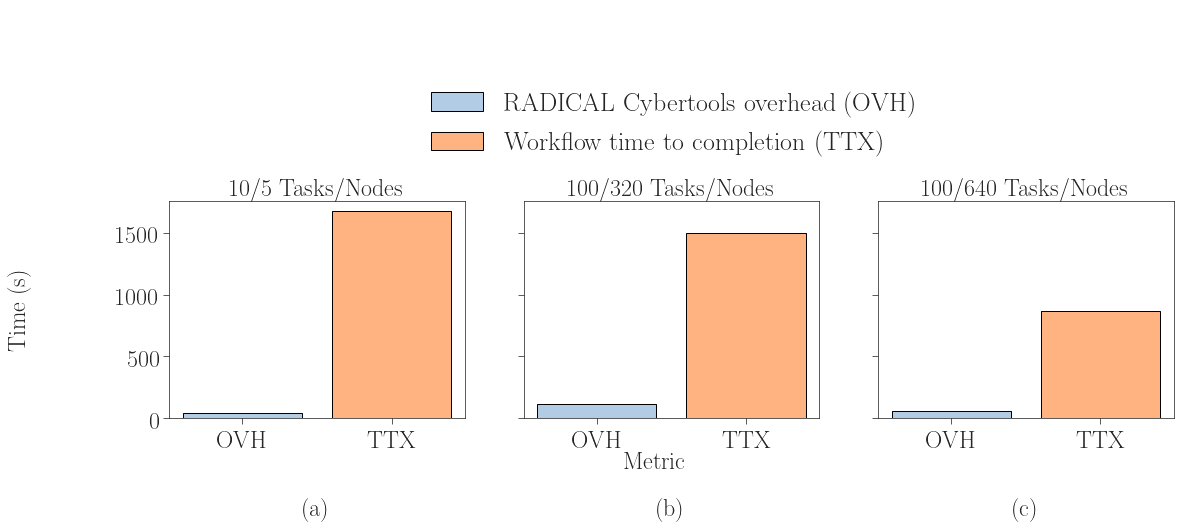

In [9]:
fwidth = 18
fhight = 4
fig, axarr = plt.subplots(1, len(suds)-1, sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    if sid != 're.session.login5.lei.018411.0003':
    
        ax = axarr[i]
        ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

        ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
        ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])

        ax.set_xlabel('(%s)' % j, labelpad=45)

        i = i+1
        j = chr(ord(j) + 1)

fig.text(0   ,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text(0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.6), fontsize=26, ncol=1)
    
plt.savefig('figures/incite2020_ovh_ttx_jsrun.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite2020_ovh_ttx_jsrun.png', dpi=300, bbox_inches='tight')

In [10]:
# get utilization information
# FIXME: remove bogus session
suds = ['re.session.login4.lei.018394.0005',
        're.session.login4.lei.018394.0006',
        're.session.login5.lei.018411.0002']
sids = [sdir+s for s in suds]

sobjs = ra.Experiment(sids, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

In [11]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

In [12]:
def update_ticks(x, pos):
    return int(x/4)

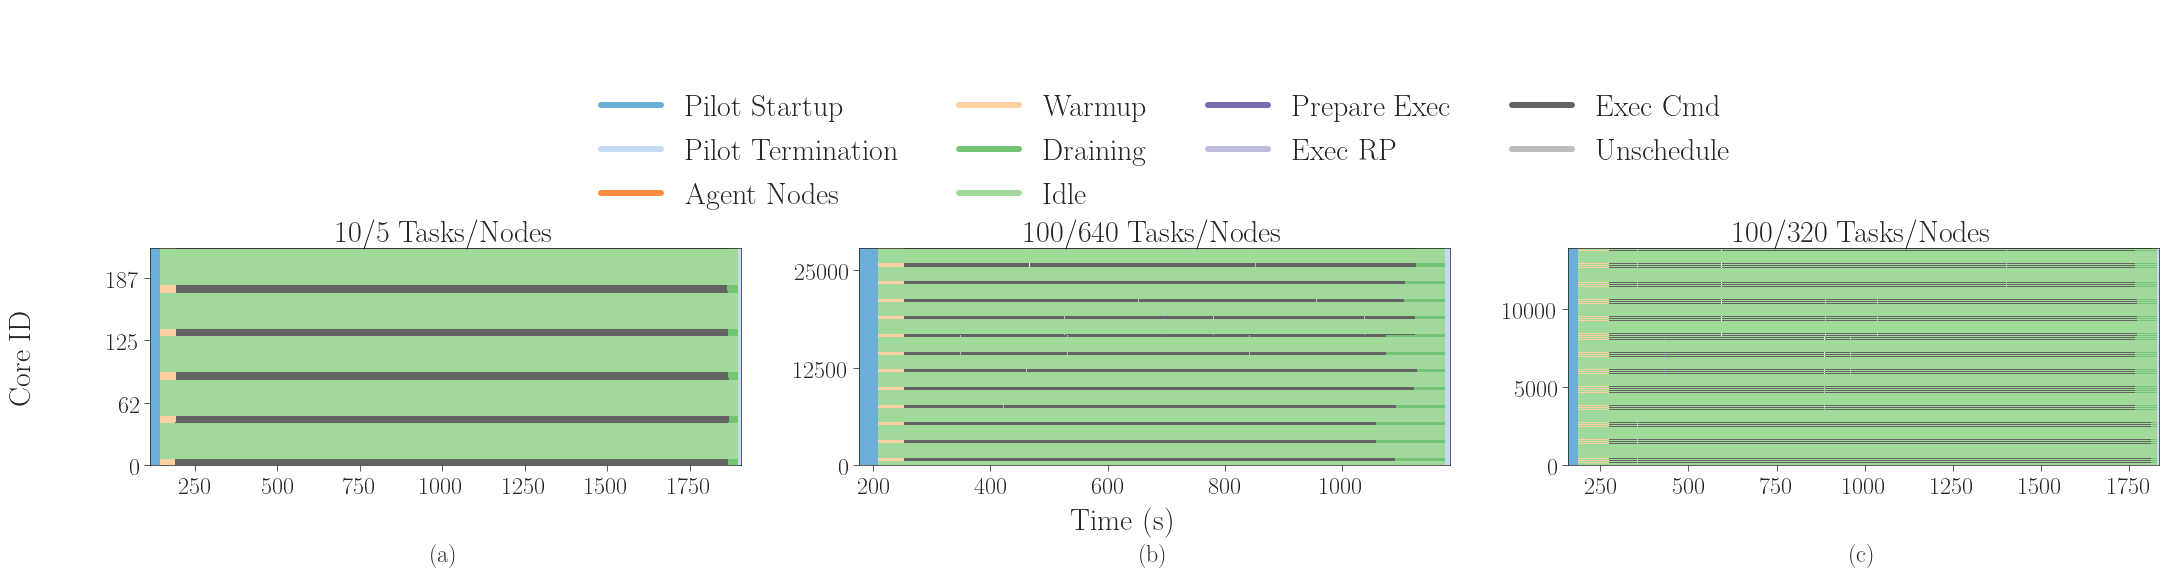

In [13]:
# core/gpu utilization over time (box plot)

fwidth = 36
fhight = 4
fig, axarr = plt.subplots(1, len(suds), sharex='col', figsize=(fwidth, fhight))  # , sharey='row')

i = 0
j = 'a'
for sid in suds:

    ax = axarr[i]
    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.set_title('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])), fontdict={'fontsize': 30})

    for metric in metrics_default:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)

# Add common axes lables
fig.text(0.07,  0.5, 'Core ID' , va='center', rotation='vertical', fontsize=30)
fig.text(0.5 , -0.1, 'Time (s)', ha='center', fontsize=30)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics_default], loc='upper center', 
           bbox_to_anchor=(0.45, 1.77), fontsize=30, ncol=4)

plt.savefig('figures/incite2020_inversions_jsrun.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite2020_inversions_jsrun.png', dpi=300, bbox_inches='tight')

In [14]:
for sid in suds:
    print(info[sid])

re.session.login4.lei.018394.0005 [10]
    Pilot Startup       :      25927.312     1.665%      ['boot', 'setup_1']
    Pilot Termination   :       6571.864     0.422%      ['term']
    Agent Nodes         :          0.000     0.000%   !  ['agent']
    Warmup              :       7371.339     0.473%      ['warm']
    Draining            :       4599.154     0.295%      ['drain']
    Idle                :    1261896.714    81.032%      ['idle']
    Prepare Exec        :          4.940     0.000%      ['exec_queue', 'exec_prep']
    Exec RP             :         35.362     0.002%      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']
    Exec Cmd            :     250869.930    16.109%      ['exec_cmd']
    Unschedule          :         14.298     0.001%      ['unschedule']
    total               :    1557291.039   100.000%      

    total               :    1557291.039   100.000%
    over                :    1557290.914   100.000%
    work                :          0.000     0.000%
    miss

In [15]:
UNIT_DURATIONS_DEBUG = {
    'consume' : {
        'u_umngr_create'               : [ {ru.EVENT: 'state'           , ru.STATE: rp.NEW                         },      
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING_PENDING     }  ],
        'u_umngr_schedule_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING_PENDING     }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING             }  ],
        'u_umngr_schedule'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING             },               
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT_PENDING  }  ],
        'u_umngr_stage_in_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT_PENDING  }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT          }  ], # push to mongodb
        'u_umngr_stage_in'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT          }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT_PENDING }  ], # wait in mongodb
        'u_agent_stage_in_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT_PENDING },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT         }  ], # pull from mongodb 
        'u_agent_stage_in'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT         },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING_PENDING    }  ], 
        'u_agent_schedule_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING_PENDING    },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING            }  ],
        'u_agent_schedule'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING            },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING_PENDING     }  ], 
        'u_agent_execute_queue'        : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING_PENDING     },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING             }  ], 
        'u_agent_execute_mkdir_start'  : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING             },  
                                         {ru.EVENT: 'exec_mkdir'      , ru.STATE: None                           }  ], 
        'u_agent_execute_mkdir'        : [ {ru.EVENT: 'exec_mkdir'      , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_mkdir_done' , ru.STATE: None                           }  ],
        'u_agent_execute_layer_start'  : [ {ru.EVENT: 'exec_mkdir_done' , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_start'      , ru.STATE: None                           }  ],
        'u_agent_execute_layer'        : [ {ru.EVENT: 'exec_start'      , ru.STATE: None                           },
                                        [{ru.EVENT: 'exec_ok'         , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_fail'       , ru.STATE: None                           } ]], # orte, ssh, mpi, ... 

        'u_agent_cu_start'             : [ {ru.EVENT: 'cu_start'        , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_cd_done'      , ru.STATE: None                           }  ], # PROBLEM: discontinuity
        'u_agent_cu_pre_execute_start' : [ {ru.EVENT: 'cu_cd_done'      , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_pre_start'    , ru.STATE: None                           }  ],
        'u_agent_cu_pre_execute'       : [ {ru.EVENT: 'cu_pre_start'    , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_pre_stop'     , ru.STATE: None                           }  ],
        'u_agent_cu_execute_start'     : [ {ru.EVENT: 'cu_pre_stop'     , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_exec_start'   , ru.STATE: None                           }  ],
        'u_agent_cu_execute'           : [ {ru.EVENT: 'cu_exec_start'   , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_exec_stop'    , ru.STATE: None                           }  ],
        'u_agent_cu_stop'              : [ {ru.EVENT: 'cu_exec_stop'    , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_stop'         , ru.STATE: None                           }  ],

        'u_agent_cu_unschedule_start'  : [ {ru.EVENT: 'exec_stop'       , ru.STATE: None                           },
                                         {ru.EVENT: 'unschedule_start', ru.STATE: None                           }  ], # PROBLEM: discontinuity
        'u_agent_cu_stage_out_start'   : [ {ru.EVENT: 'unschedule_start', ru.STATE: None                           },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING}  ],
        'u_agent_cu_stage_out_queue'   : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING},
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT        }  ],
        'u_agent_cu_stage_out'         : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT        },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT_PENDING }  ],
#         'u_agent_cu_unschedule_stop'   : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT_PENDING },
#                                          {ru.EVENT: 'unschedule_stop' , ru.STATE: None                           }  ],
        'u_agent_cu_push_to_umngr'     : [ {ru.EVENT: 'unschedule_stop' , ru.STATE: None                           },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT         }  ], # push/pull mongodb
        'u_umngr_cu_destroy'           : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT         },
                                        [{ru.EVENT: 'state'           , ru.STATE: rp.DONE                        },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.CANCELED                    },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.FAILED                      } ]]
    }
}

In [16]:
u_durations = {}

for sid in suds:
    u_durations[sid] = {}

for sid in suds:
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in UNIT_DURATIONS_DEBUG['consume'].items():
            durations[k] = unit.duration(event=v)
        u_durations[sid].update({uid: durations})

In [17]:
u_durations_df = {}
for sid,durations in u_durations.items():
    u_durations_df[sid] = pd.DataFrame.from_dict(durations, orient='index')

Text(0.5, 0, 'time (s)')

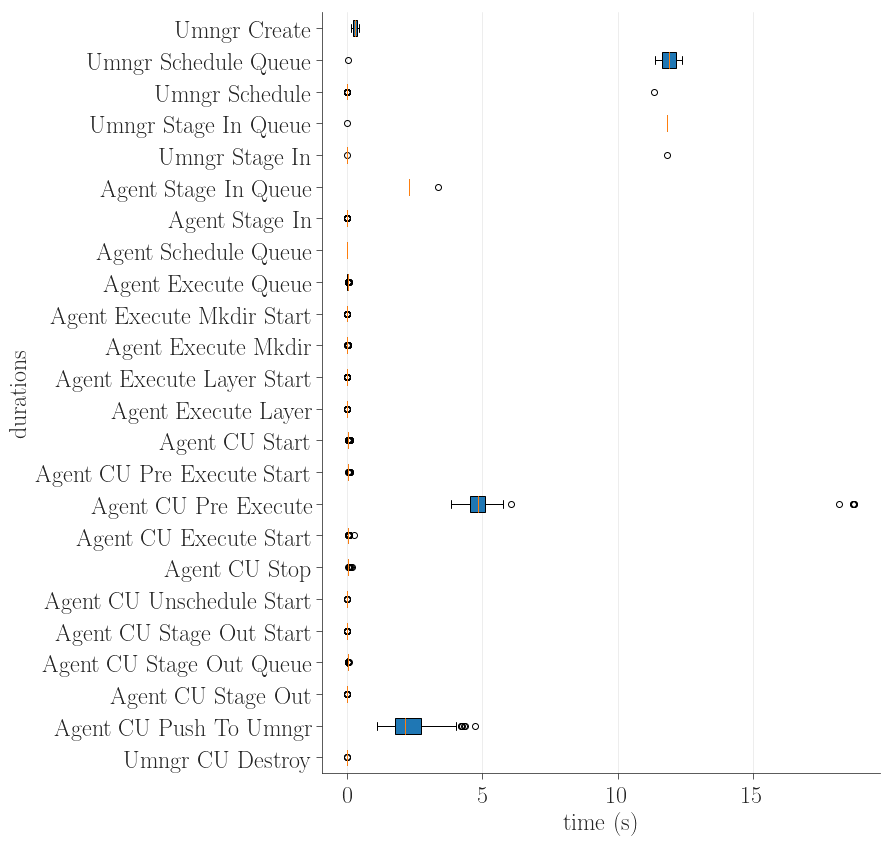

In [18]:
fig, ax  = fig_setup(figsize=(10,14))

sid = 're.session.login5.lei.018411.0002'

labels = []
muted = ['u_agent_schedule', 'u_agent_cu_execute']

durations = u_durations_df[sid].drop(muted, axis=1)

for label in durations.columns:
    labels.append(label.replace("_", " ").title().replace("U ", "").replace("Cu", "CU"))
labels = list(reversed(labels))

boxes = []
for duration in list(reversed(durations.columns)):
    boxes.append(durations[duration].values)    

plt.boxplot(boxes, patch_artist=True, labels=labels, vert=False),

ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set_axisbelow(True)

plt.ylabel('durations')
plt.xlabel('time (s)')

In [19]:
# core/gpu utilization over time (box plot)

# fwidth = 24
# fhight = 4
# fig, axarr = plt.subplots(1, len(suds), sharex='col', figsize=(fwidth, fhight))  # , sharey='row')

# i = 0
# j = 'a'
# for sid in suds:

#     ax = axarr[i]
#     ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

#     ax.boxplot([u_durations_df[sid]['load'].values, u_durations_df[sid]['unload'].values], patch_artist=True)      

#     ax.set_xlabel('(%s)' % j, labelpad=45)
#     i = i+1
#     j = chr(ord(j) + 1)

# fig.text(0.08,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
# fig.text(0.51, -0.05, 'Durations'  , ha='center', fontsize=24)
# fig.legend(['1: load', '2: unload'], loc='upper center', 
#            bbox_to_anchor=(0.5, 1.5), fontsize=26, ncol=2)